In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
from numba import njit

<h3>Loading the data</h3>

In [2]:
digits = pd.read_csv('FromScratch/digits.csv')[:10_000]
digits.shape

(10000, 785)

In [3]:
digits.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
X = digits.drop('label',axis=1).values.reshape((10_000,28,28))/255
y = digits['label'].values

In [5]:
pd.Series(y).value_counts()

1    1095
2    1045
7    1039
3    1009
6    1003
9     995
0     991
4     967
8     950
5     906
Name: count, dtype: int64

In [6]:
def display_images(X, y=None, amount=12,figsize=(8,8)):
    rows = int(np.sqrt(amount))
    columns = int(np.ceil(amount / rows))
    fig, axs = plt.subplots(rows, columns, figsize=figsize, gridspec_kw={'wspace': 0.2, 'hspace': 0.2})

    for i in range(columns * rows):
        if i >= len(X):  # Avoid accessing out-of-bounds
            break
        img = X[i]
        ax = axs[i // columns, i % columns]  # Get the correct subplot
        ax.imshow(img)
        if y is not None:
            ax.set_title("class " + str(y[i]), fontsize=8)  # Set the title with the label
        ax.axis('off')  # Hide the axes
    plt.show()

<h3>Some sample images</h3>

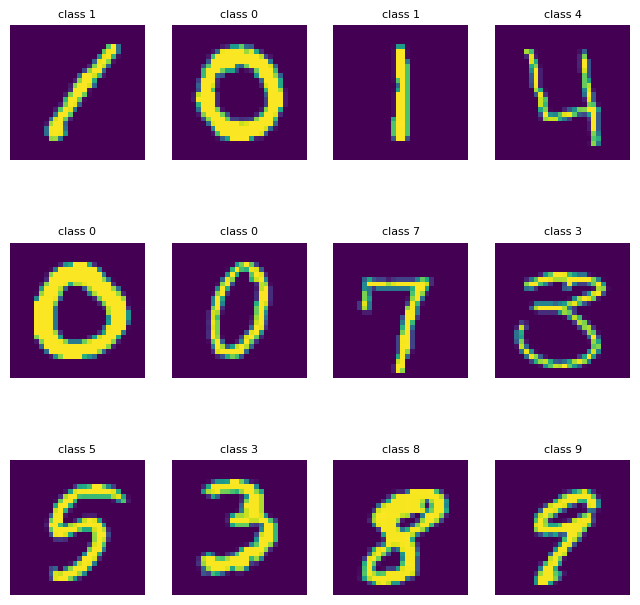

In [7]:
display_images(X,y)

<h3>Function to find bounding box of digit</h3>

In [8]:
def find_corners(matrix):
    non_zero_indices = np.argwhere(matrix != 0)
    if non_zero_indices.size == 0:
        return None  
    
    tl_row = np.min(non_zero_indices[:, 0])
    br_row = np.max(non_zero_indices[:, 0])
    
    tl_col = np.min(non_zero_indices[:, 1])
    br_col = np.max(non_zero_indices[:, 1])

    b_row = (tl_row+br_row)//2
    b_col = (tl_col+br_col)//2

    width = br_col-tl_col
    height = br_row-tl_col
    
    return tl_row,tl_col,br_row,br_col,b_row,b_col,width,height

<h3>Draw the bounding box</h3>

In [9]:
def draw_bounding_box(X):
    tl_row,tl_col,br_row,br_col,b_row,b_col,width,heightt = find_corners(X)
    box_color = X.max()*2
    bounded = X.copy()
    bounded[b_row,b_col] = box_color
    for i in range(tl_row,br_row+1):
        bounded[i][tl_col] = box_color
        bounded[i][br_col] = box_color

    for i in range(tl_col,br_col+1):
        bounded[tl_row][i] = box_color
        bounded[br_row][i] = box_color
    return bounded

In [10]:
def draw_bounding_box_on_batch(X):
    out = np.zeros_like(X)
    for i in range(len(out)):
        out[i] = draw_bounding_box(X[i])
    return out

In [11]:
bounded_X = draw_bounding_box_on_batch(X[:20])

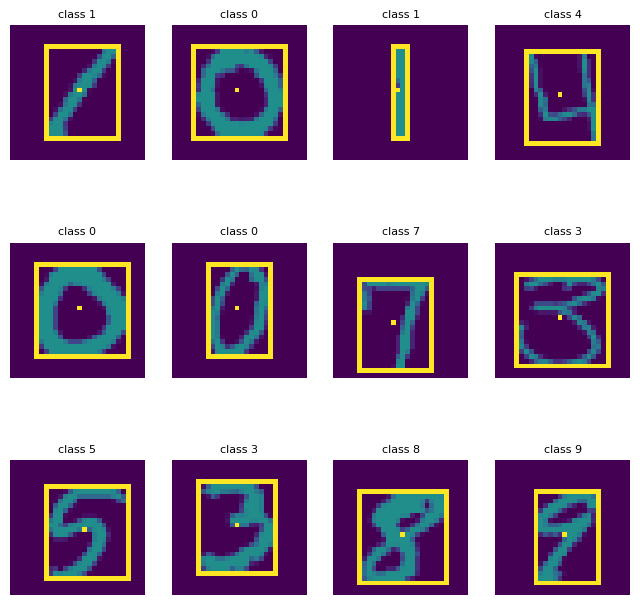

In [12]:
display_images(bounded_X,y[:20],amount=12)

In [13]:
import imageio.v3 as iio
import os

<h3>Loading background images</h3>

In [14]:
path = 'D://google_images'
google_images = []
images_to_load = 10 #change to a higher number if running this notebook
directory = os.fsencode(path)
for file in os.listdir(directory)[:images_to_load]:
    filename = os.fsdecode(file)
    if filename.endswith(".png"):
        im = iio.imread(path + "//" + filename)
        google_images.append(im)
    else:
        continue

google_images = np.array(google_images)
google_images = google_images[:,:600,:600,:]/255

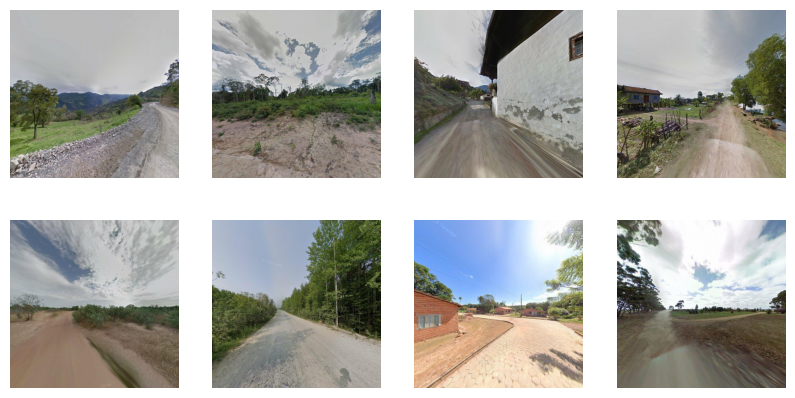

In [15]:
display_images(google_images,amount=8,figsize=(10,5))

<h3>Choosing random sections of images</h3>

In [20]:
def randomly_crop_image(X,crop_size = 128):
    image_rows,image_cols,image_channels = X.shape
    crop_top_row = np.random.randint(low=0,high=image_rows-crop_size-1)
    crop_left_col = np.random.randint(low=0,high=image_cols-crop_size-1)
    return X[crop_top_row:crop_top_row+crop_size,crop_left_col:crop_left_col+crop_size]

In [21]:
def return_random_crops(X,amount = 20,crop_size = 128):
    out = []
    ids = np.random.choice(range(len(X)),amount)
    for i in range(amount):
        out.append(randomly_crop_image(X[ids[i]],crop_size))
    return out

In [22]:
random_crops = return_random_crops(google_images,amount=16)

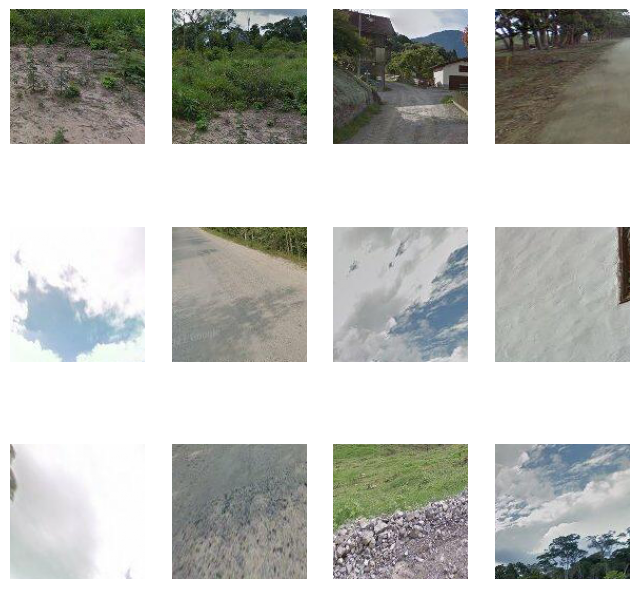

In [23]:
display_images(random_crops)

<h3>Resizing an image</h3>

In [24]:
def resize_image(image,size):
    resized_image = cv2.resize(image, (size, size), interpolation=cv2.INTER_LINEAR)
    return resized_image

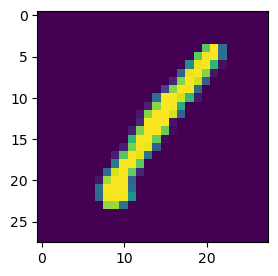

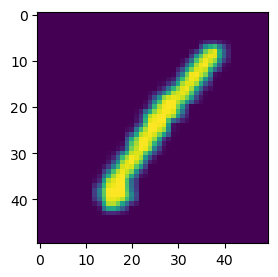

In [25]:
fig, ax = plt.subplots(figsize=(3,3))
plt.imshow(X[0])
plt.show()
fig, ax = plt.subplots(figsize=(3,3))
plt.imshow(resize_image(X[0],50))
plt.show()

<h3>Placing randomly a digit in an image</h3>

In [26]:
@njit
def randomly_place_digit_in_image(image, digit):
    digit_rows, digit_cols = digit.shape
    image_rows, image_cols, image_channels = image.shape

    # Get a random top-left corner position for placing the digit in the image
    top_row = np.random.randint(0, image_rows - digit_rows)
    left_col = np.random.randint(0, image_cols - digit_cols)

    out = image.copy()
    avg_pixel = np.mean(out[top_row:top_row+digit_rows, left_col:left_col+digit_cols,:])
    # Iterate through the digit and place it onto the image
    for row in range(digit_rows):
        for col in range(digit_cols):
            if digit[row, col] != 0:  # Only place non-zero pixels
                for channel in range(image_channels):
                    val = digit[row,col] if avg_pixel <0.5 else 1-digit[row,col]
                    out[top_row + row, left_col + col, channel] = val
                    
    return out,top_row,left_col

In [27]:
def randomly_place_digits_in_images(images,digits):
    assert len(images) == len(digits)
    out = []
    bounded_out = []
    for i in range(len(images)):
        image_rows,image_cols,image_channels = images[i].shape
        digit_rows,digit_cols = digits[i].shape
        new_digit_size =  np.random.randint(low=digit_rows,high=image_rows*0.7)
        resized_digit = resize_image(digits[i],new_digit_size)
        
        new_image,top_row,left_col = randomly_place_digit_in_image(images[i],resized_digit) 
        out.append(new_image)
        bounded = new_image.copy()
        tl_row,tl_col,br_row,br_col,b_row,b_col,width,height = find_corners(resized_digit)
        
        tl_row += top_row
        br_row += top_row
        tl_col += left_col
        br_col += left_col
        b_row += top_row
        b_col += left_col
        box_color = 1.3
        bounded[b_row-3:b_row+3,b_col-3:b_col+3,0] = box_color
        
        for i in range(tl_row,br_row+1):
            bounded[i,tl_col-2:tl_col+2,0] = box_color
            bounded[i,br_col-2:br_col+2,0] = box_color
    
        for i in range(tl_col,br_col+1):
            bounded[tl_row-2:tl_row+2,i,0] = box_color
            bounded[br_row-2:br_row+2,i,0] = box_color
        bounded_out.append(bounded/box_color)
    return out,bounded_out

<h3>Testing that the functions work properly</h3>

In [29]:
samples,bounded_samples = randomly_place_digits_in_images(random_crops[:10],X[:10])

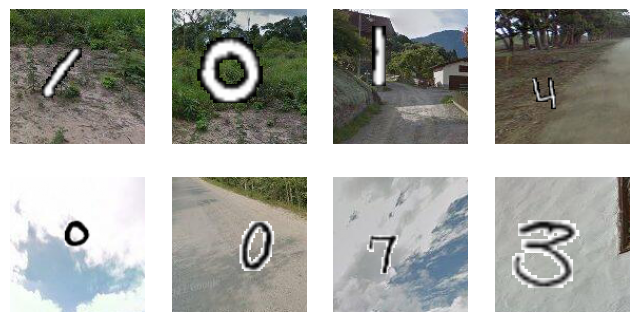

In [30]:
display_images(samples,amount=8,figsize=(8,4))

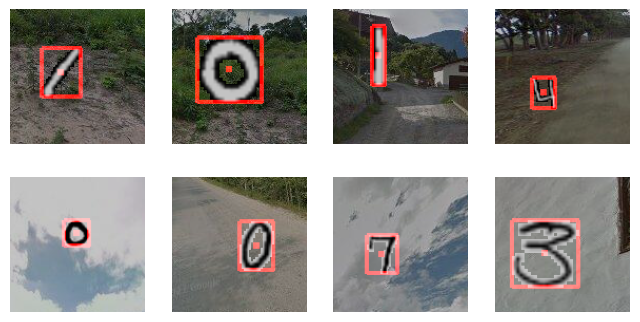

In [31]:
display_images(bounded_samples,amount=8,figsize=(8,4))

<h3>Saving the dataset</h3>

In [32]:
def create_dataset(images,digits,y,dataset_size = 64):
    num_images = len(images)
    num_digits = len(digits)
    image_rows,image_cols,image_channels = images[0].shape
    data = np.zeros((dataset_size,5 + image_rows*image_cols*image_channels))
    columns = ["digit","center_row","center_col","width","height"] + ["pixel " + str(i) for i in range(image_rows*image_cols*image_channels)]
    for i in range(dataset_size):
        if i > dataset_size//2:
            j = np.random.choice(range(num_images))
            new_image = images[j].flatten()
            data[i,0] = -1
            data[i,[1,2,3,4]] = -1
            data[i,5:] = new_image
            
        else:
            j = np.random.choice(range(num_images))
            k = np.random.choice(range(num_digits))


            digit_rows,digit_cols = digits[k].shape
            new_digit_size =  np.random.randint(low=digit_rows,high=image_rows*0.7)
            resized_digit = resize_image(digits[k],new_digit_size)
        
            
            new_image,top_row,left_col = randomly_place_digit_in_image(images[j],resized_digit) 
            tl_row,tl_col,br_row,br_col,b_row,b_col,width,height = find_corners(resized_digit)
            
            tl_row += top_row
            br_row += top_row
            tl_col += left_col
            br_col += left_col
            b_row += top_row
            b_col += left_col
    
            data[i,0] = int(y[k])
            data[i,[1,2,3,4]] = np.array([int(b_row),int(b_col),int(width),int(height)])
            data[i,5:] = new_image.flatten()
            
    return pd.DataFrame(data,columns=columns)

In [33]:
random_crops = return_random_crops(google_images,amount=20)
dataset = create_dataset(images=random_crops,digits=X,y=y,dataset_size=4)
dataset.head()

,digit,center_row,center_col,width,height,pixel 0,pixel 1,pixel 2,pixel 3,pixel 4,...,pixel 49142,pixel 49143,pixel 49144,pixel 49145,pixel 49146,pixel 49147,pixel 49148,pixel 49149,pixel 49150,pixel 49151
0,1.0,91.0,47.0,13.0,24.0,0.380392,0.407843,0.278431,0.317647,0.345098,...,0.572549,0.643137,0.611765,0.568627,0.643137,0.611765,0.568627,0.631373,0.600000,0.556863
1,4.0,102.0,43.0,22.0,34.0,0.560784,0.603922,0.611765,0.498039,0.541176,...,0.247059,0.286275,0.329412,0.211765,0.258824,0.298039,0.192157,0.290196,0.329412,0.223529
2,1.0,103.0,34.0,22.0,23.0,0.666667,0.666667,0.658824,0.690196,0.690196,...,0.372549,0.368627,0.364706,0.345098,0.411765,0.407843,0.388235,0.329412,0.325490,0.305882
3,-1.0,-1.0,-1.0,-1.0,-1.0,0.486275,0.643137,0.925490,0.490196,0.647059,...,0.972549,0.537255,0.686275,0.972549,0.533333,0.682353,0.960784,0.533333,0.682353,0.960784


<h3>It works! , Now let's create a bigger dataset and save it in a folder</h3>

<h3>I'll do it in batches of size 64, 1000 times, Overall 64_000 samples</h3>

<h4>This is extremly slow and memory consuming so dont run this unless you're sure you want to create a dataset</h4>

In [ ]:
for i in range(0,1000):
    if i%5 == 0:
        print("Creating dataset ", i)
    random_crops = return_random_crops(google_images,amount=128)
    dataset = create_dataset(ima
                             
                             ges=random_crops,digits=X,y=y,dataset_size=64)
    dataset.to_csv('D://DigitDetectionDataset//' + str(i) + ".csv",index=False)